In [199]:
import pandas as pd
# https://jmotif.github.io/sax-vsm_site/morea/algorithm/znorm.html
q = pd.Series(np.array([2.02, 2.33, 2.99, 6.85, 9.20, 8.80, 7.50, 6.00, 5.85, 3.85, 4.85, 3.85, 2.22, 1.45, 1.34]))
c = pd.Series(np.array([-0.12, -0.16, -0.13,  0.28,  0.37,  0.39,  0.18,  0.09,  0.15, -0.06,  0.06, -0.07, -0.13, -0.18, -0.26]))

# Z Normalization

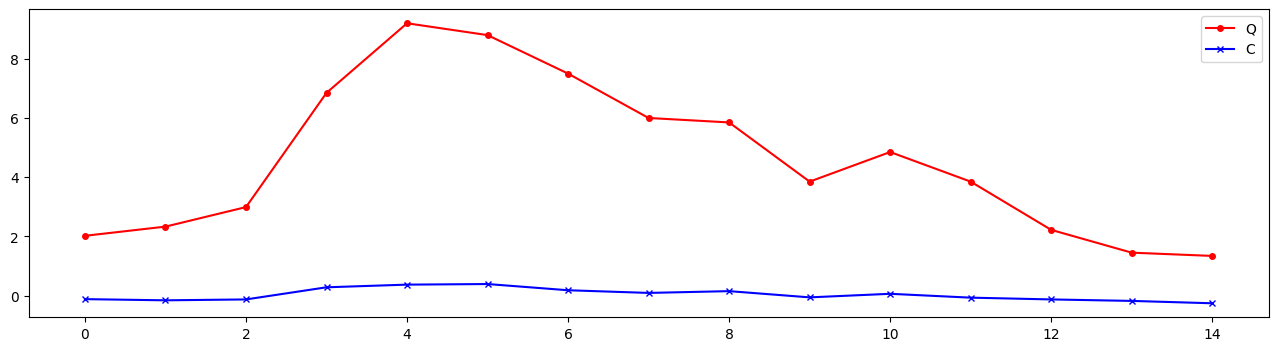

In [200]:
# https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.utils.plotting.plot_series.html
from sktime.utils.plotting import plot_series
fig, ax = plot_series(q, c, markers=["o", "x"], colors=["red", "blue"], labels=["Q", "C"]) 


In [201]:
def z_normalize_sketch(series):
    mean = series.mean()  # Calculate the mean
    std = series.std(ddof=0) # Calculate the population standard deviation instead of the default sample standard deviation
    
    # Apply z-normalization formula: (x - mean) / std
    normalized_series = (series - mean) / std
    
    return normalized_series

In [203]:
q_znorm = z_normalize_sketch(q)

In [204]:
print(q_znorm)

0    -1.014066
1    -0.892535
2    -0.633791
3     0.879467
4     1.800751
5     1.643937
6     1.134290
7     0.546237
8     0.487431
9    -0.296640
10    0.095395
11   -0.296640
12   -0.935659
13   -1.237526
14   -1.280650
dtype: float64


In [205]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def z_normalize(series):
    # Reshape the series to 2D (required by StandardScaler)
    reshaped = series.values.reshape(-1, 1)
    
    # Apply z-normalization
    scaler = StandardScaler()
    normalized = scaler.fit_transform(reshaped)
    
    # Convert back to pandas Series
    return pd.Series(normalized.flatten(), index=series.index)


In [207]:
q_znorm = z_normalize_sketch(q)

In [208]:
print(q_znorm)

0    -1.014066
1    -0.892535
2    -0.633791
3     0.879467
4     1.800751
5     1.643937
6     1.134290
7     0.546237
8     0.487431
9    -0.296640
10    0.095395
11   -0.296640
12   -0.935659
13   -1.237526
14   -1.280650
dtype: float64


In [209]:
c_znorm = z_normalize(c)


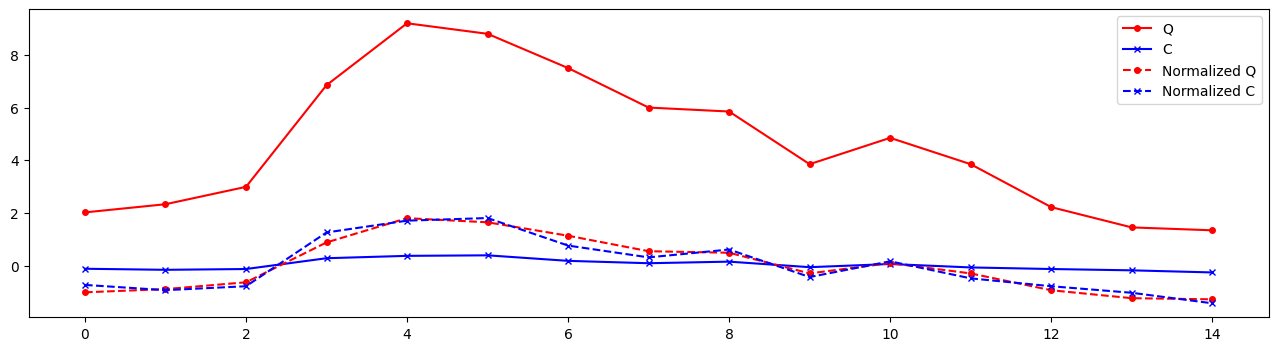

In [219]:
fig, ax = plot_series(q, c, q_znorm, c_znorm, markers=["o", "x", "o", "x"], colors=["red", "blue", "red", "blue"], labels=["Q", "C", "Normalized Q", "Normalized C"]) 
ax.lines[2].set_linestyle("--")  # Dashed line for the first series
ax.lines[3].set_linestyle(("--"))   # Dotted line for the second series
# https://stackoverflow.com/questions/51054529/manipulate-linestyle-in-matplotlib-legend
ax.legend()
plt.show()

# ED, Squared ED, DTW

In [229]:
# Oridinary ED
# https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.euclidean_distance.html
import numpy as np
from sktime.distances import euclidean_distance
euclidean_distance(q.to_numpy(), c.to_numpy()), euclidean_distance(q_znorm.to_numpy(), c_znorm.to_numpy())

(np.float64(19.942780648645762), np.float64(0.7986926618401662))

In [226]:
# Squared ED
# https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.distances.squared_distance.html
from sktime.distances import squared_distance
squared_distance(q_znorm.to_numpy(), c_znorm.to_numpy())

np.float64(0.6379099680773301)

In [228]:
# DTW
import numpy as np
from sktime.distances import dtw_distance
dtw_distance(q_znorm.to_numpy(), c_znorm.to_numpy())

np.float64(0.6379099680773301)

# Uniform Scaling

In [230]:
c_x1 = np.linspace(0, 4 * np.pi, 100)
c_y1 = np.sin(c_x1) * 50 + 50  # Scale to range around 0~100
c_x2 = np.linspace(0, 1, 50)
c_y2 = np.piecewise(x2, [x2 < 0.5, x2 >= 0.5], [lambda x: 2*x, lambda x: 2*(1-x)])
c_y2 = c_y2 * 50  # Scale it similarly
offset = c_y1[-1] - c_y2[0]
c_y2 = c_y2 + offset
c = np.concatenate([c_y1, c_y2])


In [231]:
q_x = np.linspace(0, 4 * np.pi, 70)
q = np.sin(q_x) * 50 + 50  # Scale to range around 0~100

In [261]:
m = len(q)
n = len(c)
print(m, n)

70 150


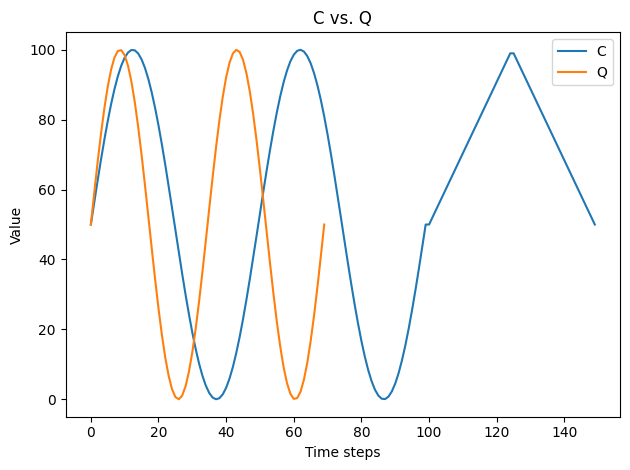

In [232]:
plt.plot(c, label='C')
plt.plot(q, label='Q')
plt.title('C vs. Q')
plt.xlabel('Time steps')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

In [245]:
# https://stackoverflow.com/questions/66934748/how-to-stretch-an-array-to-a-new-length-while-keeping-same-value-distribution
def interp1d(array: np.ndarray, new_len: int) -> np.ndarray:
    la = len(array)
    return np.interp(np.linspace(0, la - 1, num=new_len), np.arange(la), array)

In [280]:
c_prefix = c[:100]

In [281]:
c_prefix_interpolated = interp1d(c_prefix, new_len=len(q))

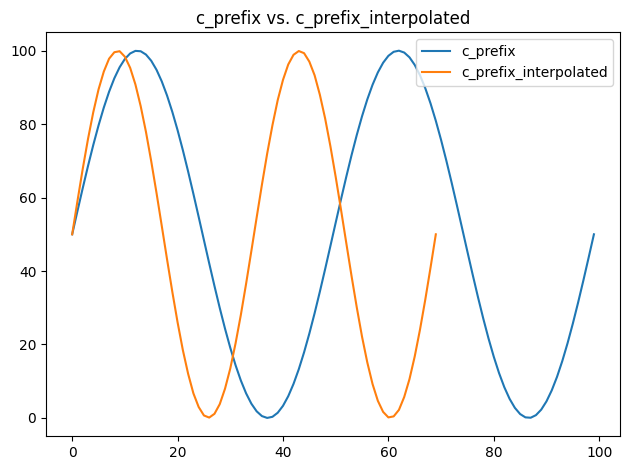

In [282]:
plt.plot(c_prefix, label='c_prefix')
plt.plot(c_prefix_interpolated, label='c_prefix_interpolated')
plt.title('c_prefix vs. c_prefix_interpolated')
plt.legend()
plt.tight_layout()
plt.show()


In [283]:
len(c_prefix), len(c_prefix_interpolated)

(100, 70)

In [284]:
euclidean_distance(q, c_prefix_interpolated)

np.float64(0.4318021168070546)

In [285]:
l = 2 # scaling_factor 

In [298]:
# US
import math
best_so_far = np.inf
for k in range(math.ceil(m/l), min(l*m, n)):
    c_prefix = c[:k]   
    c_prefix_interpolated = interp1d(c_prefix, new_len=m)
    dtw_distance
    us_dist = euclidean_distance(q, c_prefix_interpolated)
    # us_dist = dtw_distance(q, c_prefix_interpolated)
    if us_dist < best_so_far:
        best_so_far = us_dist
        best_k = k


In [299]:
best_so_far, best_k, best_k/m*100 # best_k/m*100 is the best scaling factor

(np.float64(0.4318021168070546), 100, 142.85714285714286)

In [300]:
# US + DTW
best_so_far = np.inf
for k in range(math.ceil(m/l), min(l*m, n)):
    c_prefix = c[:k]   
    c_prefix_interpolated = interp1d(c_prefix, new_len=m)
    dtw_distance
    dtw_dist = dtw_distance(q, c_prefix_interpolated)
    if dtw_dist < best_so_far:
        best_so_far = dtw_dist
        best_k = k

In [301]:
best_so_far, best_k, best_k/m*100 # best_k/m*100 is the best scaling factor

(np.float64(0.18645306807905324), 100, 142.85714285714286)

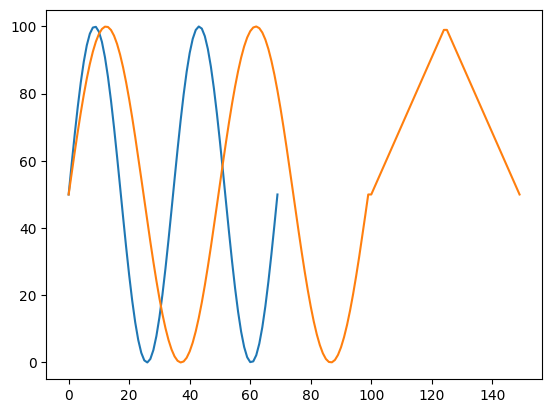

In [314]:
plt.plot(q)
plt.plot(c)

In [316]:
dtw_distance(q, c)

np.float64(41157.42316279798)

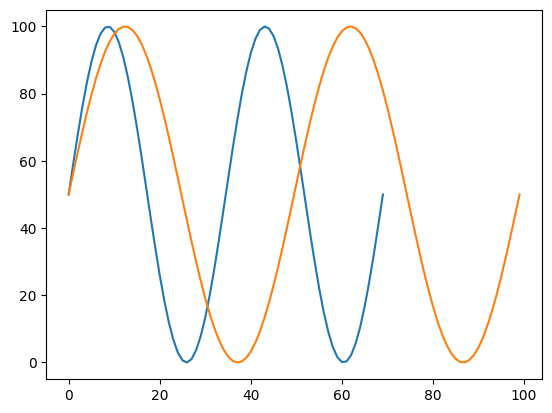

In [308]:
plt.plot(q)
plt.plot(c[:100])

In [317]:
dtw_distance(q, c[:len(q)])

np.float64(72896.27205022328)

In [313]:
dtw_distance(q, c[:100])

np.float64(341.09663218572496)